In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from glob import glob

import sklearn
import numpy as np
import pandas as pd
from math import sqrt

from sklearn.metrics import confusion_matrix
# from sklearn.metrics import ConfusionMatrixDisplay  # error

file_path = Path.cwd()
print(file_path)

/Users/apartin/Box Sync/projects/DrugResponseViz/notebooks


In [2]:
cancer_types = pd.read_csv(file_path/'../data/combined_cancer_types', sep='\t', names=['CELL', 'CTYPE'])
df = pd.read_csv('../all_meta.csv')
df['AUC_cls'] = [0 if v>0.5 else 1 for v in df['AUC'].values]
df = df.reset_index().rename(columns={'index': 'idx'})
display(df[:3])

,idx,SOURCE,CELL,DRUG,STUDY,AUC,IC50,EC50,EC50se,R2fit,Einf,HS,AAC1,AUC1,DSS1,AUC_cls
0,0,CCLE,CCLE.42MGBA,CCLE.1,fake_exp,0.8126,5.570,5.764,0.0229,0.9972,0.3626,2.899,0.1216,0.8784,0.1008,0
1,1,CCLE,CCLE.697,CCLE.1,fake_exp,0.7692,5.379,5.379,0.8163,0.8768,0.0000,1.299,0.1146,0.8854,0.0840,0
2,2,CCLE,CCLE.769P,CCLE.1,fake_exp,0.8371,NaN,6.524,0.1646,0.8962,0.6129,3.376,0.1576,0.8424,0.1209,0


In [3]:
# def plot_target(data_to_plot, y_name, x_name, kind='box', hue_name=None, height=None, aspect=None):
#     """ Plot function. """
#     if hue_name:
#         g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, hue=hue_name, **args);
#     else:
#         g = sns.catplot(data=data_to_plot, y=y_name, x=x_name, kind=kind, **args);
#     return g

0.0001


Text(0, 0.5, 'Count')

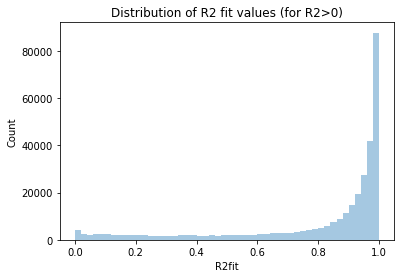

In [4]:
th = 0
print(df.R2fit[df.R2fit>th].min())
ax = sns.distplot(df.R2fit[df.R2fit>th], bins=50, kde=False);
ax.set_title('Distribution of R2 fit values (for R2>0)')
ax.set_ylabel('Count')

In [5]:
# Bin R2fit values
bins_ = np.arange(0, 1.1, 0.1).tolist()
bins = [-np.Inf]
bins.extend(bins_)
df['R2_Fit_bin'] = pd.cut(df.R2fit, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise')
# df['R2_Fit_bin'] = df['R2_Fit_bin'].astype(str)

In [6]:
for c in df['R2_Fit_bin'].cat.categories:
    aa = df[df['R2_Fit_bin']==c]
    print(c, aa.shape[0])

(-inf, 0.0] 46108
(0.0, 0.1] 13302
(0.1, 0.2] 10955
(0.2, 0.3] 9148
(0.3, 0.4] 9640
(0.4, 0.5] 8983
(0.5, 0.6] 10377
(0.6, 0.7] 13208
(0.7, 0.8] 18926
(0.8, 0.9] 38753
(0.9, 1.0] 190857


In [7]:
aa = df.groupby(['R2_Fit_bin', 'AUC_cls']).agg({'idx': len}).reset_index()
aa = pd.pivot_table(aa, values='idx', index='R2_Fit_bin', columns='AUC_cls')
aa.columns.name = None
aa = aa.reset_index()
aa = aa.rename(columns={0: 'no_rsp', 1: 'rsp'})
aa['tot'] = aa.no_rsp + aa.rsp
aa['rsp_ratio'] = aa.rsp/(aa.rsp + aa.no_rsp)

bin_cnt = aa
bin_cnt

,R2_Fit_bin,no_rsp,rsp,tot,rsp_ratio
0,"(-inf, 0.0]",45820,288,46108,0.006246
1,"(0.0, 0.1]",13152,150,13302,0.011276
2,"(0.1, 0.2]",10832,123,10955,0.011228
3,"(0.2, 0.3]",9001,147,9148,0.016069
4,"(0.3, 0.4]",9422,218,9640,0.022614
5,"(0.4, 0.5]",8704,279,8983,0.031059
6,"(0.5, 0.6]",10064,313,10377,0.030163
7,"(0.6, 0.7]",12808,400,13208,0.030285
8,"(0.7, 0.8]",18276,650,18926,0.034344
9,"(0.8, 0.9]",37267,1486,38753,0.038345


In [8]:
tot = bin_cnt['tot'].values.sum()
prc = []
for i in range(bin_cnt.shape[0]):
    prc.append( sum(bin_cnt.loc[:i, 'tot'].values)/tot )  # cummulative percent
bin_cnt['cum_prcnt'] = prc
display(bin_cnt)

In [10]:
df.groupby(['R2_Fit_bin', 'SOURCE']).agg({'idx': len}).reset_index()[:7]

,R2_Fit_bin,SOURCE,idx
0,"(-inf, 0.0]",CCLE,999
1,"(-inf, 0.0]",CTRP,28106
2,"(-inf, 0.0]",GDSC,14876
3,"(-inf, 0.0]",NCI60,2029
4,"(-inf, 0.0]",gCSI,98
5,"(0.0, 0.1]",CCLE,292
6,"(0.0, 0.1]",CTRP,9984


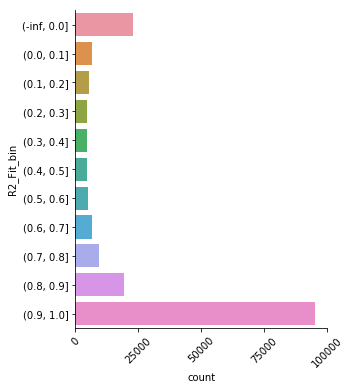

In [87]:
# g = sns.catplot(data=df, x='R2_Fit_bin', kind='bar', orient='h');  # doesn't work

# g = sns.catplot(data=df, x='R2_Fit_bin', kind='count');

g = sns.catplot(data=df, y='R2_Fit_bin', kind='count');
# g = sns.catplot(data=df, y='R2_Fit_bin', kind='count', row='SOURCE');
# g = sns.catplot(data=df, y='R2_Fit_bin', kind='count', hue='SOURCE');
# g.xlabel('Total Samples')
# g.set_ylabel('R2 Fit of AUC curve')
g.set_xticklabels(rotation=45);

# Analyze the effect ot R2 Fit

In [69]:
path = Path('/Users/apartin/Box Sync/projects/DrugResponseViz/R2fit_analysis')
trn_rv_dirs = [Path(d) for d in glob(str(path/'trn_rv0.*'))]

In [74]:
# Combine results
te_scr = []
for p in trn_rv_dirs:
    dd = pd.read_csv( p/'te_scores.csv' )
    dd.insert( loc=0, column='rv', value=str(p).split('/')[-1].split('_rv')[-1] )
    te_scr.append(dd)
    
te_scr = pd.concat(te_scr, axis=0)

# Agg results
te_scr['mcc_median'] = te_scr['mcc']
te_scr['mcc_std'] = te_scr['mcc']
te_scr['brier_median'] = te_scr['brier']
te_scr['brier_std'] = te_scr['brier']
te_scr['f1_median'] = te_scr['f1_score']
te_scr['f1_std'] = te_scr['f1_score']

te_scr = te_scr.groupby(['rv']).agg(
    {'mcc_median': 'median',   'mcc_std': 'std',
     'brier_median': 'median', 'brier_std': 'std',
     'f1_median': 'median',   'f1_std': 'std'}).reset_index()

display( te_scr )

,rv,mcc_median,mcc_std,brier_median,brier_std,f1_median,f1_std
0,0.0,0.601335,0.012717,0.019008,0.000504,0.973964,0.000853
1,0.1,0.604802,0.011972,0.019516,0.000562,0.973337,0.000903


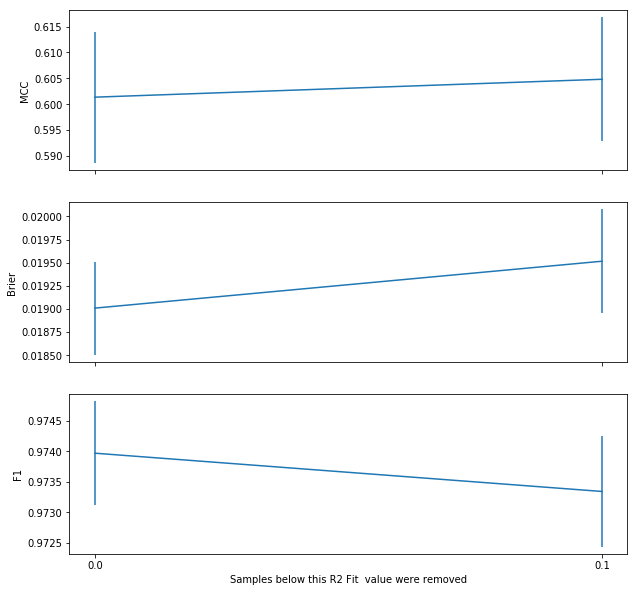

In [84]:
# _, ax = plt.subplots(1,3,figsize=(15,7))
_, ax = plt.subplots(3, 1, figsize=(10,10), sharex=True)
ax = ax.ravel()

ax[0].errorbar(te_scr.rv, te_scr.mcc_median, yerr=te_scr.mcc_std, label='MCC');
ax[0].set_ylabel('MCC')
ax[1].errorbar(te_scr.rv, te_scr.brier_median, yerr=te_scr.brier_std, label='Brier');
ax[1].set_ylabel('Brier')
ax[2].errorbar(te_scr.rv, te_scr.f1_median, yerr=te_scr.f1_std, label='F1');
ax[2].set_ylabel('F1')
ax[2].set_xlabel('Samples below this R2 Fit  value were removed');